In [1]:
import os
import warnings
import glob
import pickle
import numpy as np
from scipy import io
from mne.viz import plot_topomap
from matplotlib import colors, cm, gridspec, pyplot as plt

plt.style.use("seaborn-dark")
plt.rcParams.update({"xtick.labelsize": 15, "ytick.labelsize": 15})

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
CAF_DOSE = 200 # the caffeine dose in mg (200 or 400)
AGE_GROUP = -1 # -1: all, 0: up to age 30, 1: from age 30

SIGNIFICANT_P = 0.05 # weak significance threshold (grey dots)
SIGNIFICANT_P_STRONG = 0.01 # strong significance threshold (white dots)

PROJECT_PATH = "../data" # path to where the EEG sensor position file is stored
STATS_RESULTS_PATH = "../results/final/statistics200" # directory where statistics results are stored
SINGLE_ML_RESULTS_PATH = "../results/final/singleML200" # directory where single feature ML results are stored
FIGURE_PATH = "../figures" # directory where the figures are saved

STAGES = ["NREM", "REM"] # sleep stages to include in the figure
BANDS = ["delta", "theta", "alpha", "sigma", "beta", "low gamma"] # frequency bands to include in the figure

In [3]:
# get age suffix for loading the data depending on age group parameter
age_suffix = ""
if AGE_GROUP == 0:
    age_suffix = "_age_t30"
elif AGE_GROUP == 1:
    age_suffix = "_age_f30"
elif AGE_GROUP != -1:
    raise Exception(f"Unknown age group {AGE_GROUP}")

# load EEG sensor positions to be used in the topomaps
sensor_pos = io.loadmat(os.path.join(PROJECT_PATH, "Coo_caf"))["Cor"].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

In [4]:
def fmt_feat(name):
    name = name.replace("PSD", "").replace('_', ' ').replace('Shan', '').replace("LZiv", "LZc").replace("OneOverF", f"aperiodic slope").replace("DFA", "scaling exponent")
    return name

# Load statistic results

In [5]:
# load statistics data for all features
with open(os.path.join(STATS_RESULTS_PATH, f"statistics{age_suffix}.pickle"), "rb") as file:
    diff = pickle.load(file)

# Load Single-Feature ML results

In [6]:
# load classification results
scores = {}
for path in glob.glob(os.path.join(SINGLE_ML_RESULTS_PATH, f'scores_*_avg{age_suffix}.pickle')):
    if AGE_GROUP == -1 and "age" in path.split(os.sep)[-1]:
        continue
    clf = path.split(os.sep)[-1].split('.')[0].split('_')[1]
    with open(path, 'rb') as file:
        scores[clf] = pickle.load(file)

assert len(scores) > 0, "No data found"

# correct for multiple comparisons with maximum statistics
for clf in scores.keys():
    for stage in scores[clf].keys():
        for feat in scores[clf][stage].keys():
            # get maximum accuracies across channels
            permutations = [scores[clf][stage][feat][elec][1] for elec in range(len(scores[clf][stage][feat]))]
            permutations = np.sort(np.array(permutations).max(axis=0))

            # compute corrected accuracy thresholds
            threshold = permutations[-int(permutations.shape[0] * SIGNIFICANT_P + 1)]
            threshold_strong = permutations[-int(permutations.shape[0] * SIGNIFICANT_P_STRONG + 1)]

            # save new thresholds
            for elec in range(len(scores[clf][stage][feat])):
                scores[clf][stage][feat][elec] = list(scores[clf][stage][feat][elec])
                scores[clf][stage][feat][elec][-1] = threshold
                scores[clf][stage][feat][elec] += [threshold_strong]

# Create single age group figure

In [7]:
def create_figure(data_stats, data_ml, features, classifiers,
                  colormap_stats="coolwarm", colormap_ml="Greens", weak_marker_color=[0.6, 0.6, 0.6],
                  fontsize_small=15, fontsize_big=20, show=True):
    num_stages, num_clf, num_features = len(STAGES), len(data_ml) + 1, len(features)
    
    fig, axes = plt.subplots(num_features + 1, num_stages * num_clf + 1 + (num_stages - 1),
                             figsize=(12, num_features * 1.5 + 1),
                             gridspec_kw=dict(width_ratios=sum([[0.1] + [1] * num_clf] * num_stages, []),
                                              height_ratios=[1] * num_features + [0.1],))

    # annotate features
    for i, feat in enumerate(features):
        feat = fmt_feat(feat)
        axes[i,0].annotate(feat, xy=(1, 0.5), ha='right', va='center', fontsize=fontsize_small)
        axes[i,0].axis("off")
    
    # get gridspec and remove colorbar row of axes
    gs = axes[0,0].get_gridspec()
    for ax in axes[-1]:
        ax.remove()
    # remove spacing axes
    for i in range(1, len(STAGES)):
        for ax in axes[:-1, i * num_clf + 1]:
            ax.remove()
            
    # add titles
    for i in range(len(STAGES)):
        axes[0, i * (num_clf + 1) + 1].set_title("T-values", fontsize=fontsize_small)
        for j, clf in enumerate(classifiers):
            axes[0, i * (num_clf + 1) + 2 + j].set_title(clf, fontsize=fontsize_small)
    
    axes = axes[:,sum([[False] + [True] * num_clf] * num_stages, [])]
    for i_stage, stage in enumerate(STAGES):
        # add sleep stage titles
        x_text = np.mean([
            (ax.get_position().x0 + ax.get_position().x1) / 2
            for ax in axes[0, i_stage * num_clf:(i_stage + 1) * num_clf]]
        )
        fig.text(x_text, 0.99, stage, fontsize=fontsize_big, ha="center", va="bottom", weight="bold")
        
        # compute statistics value range
        vmin_stats = min([min(data_stats[stage][feat]["t_statistic"]) for feat in features])
        vmax_stats = max([max(data_stats[stage][feat]["t_statistic"]) for feat in features])
        absvmax_stats = max(abs(vmin_stats), abs(vmax_stats))
        vmin_stats, vmax_stats = -absvmax_stats, absvmax_stats
        
        # compute ML value range
        vmin_ml = 0.5
        vmax_ml = max([max([max([data_ml[clf][stage][feat][ch][0] for ch in range(len(data_ml[clf][stage][feat]))]) for feat in features]) for clf in classifiers])
        print(stage, vmax_ml)
        for j_feat, feat in enumerate(features):
            # ============ statistics results ============
            # get significance marker params
            mask = data_stats[stage][feat]['p_value'] < SIGNIFICANT_P
            marker_colors = [weak_marker_color] * len(mask)
            for i in np.where(data_stats[stage][feat]['p_value'] < SIGNIFICANT_P_STRONG)[0]:
                marker_colors[i] = 'w'
            marker_colors = np.array(marker_colors)[mask]
            
            # plot topomap
            mappable_stats = plot_topomap(data_stats[stage][feat]['t_statistic'],
                                          sensor_pos,
                                          mask=mask,
                                          mask_params={'markersize': 8, 'markeredgewidth': 0.3, 'markerfacecolor': marker_colors},
                                          cmap=colormap_stats,
                                          axes=axes[j_feat, i_stage * num_clf],
                                          contours=False,
                                          show=False,
                                          vmin=vmin_stats,
                                          vmax=vmax_stats,)[0]
            
            # ============ ML results ============
            for k_clf, clf in enumerate(classifiers):
                # get data for plotting
                acc = [score[0] for score in data_ml[clf][stage][feat]]
                threshold = np.array([score[2] for score in data_ml[clf][stage][feat]])
                threshold_strong = np.array([score[3] for score in data_ml[clf][stage][feat]])

                # get significance marker params
                mask = acc >= threshold
                mask_strong = acc >= threshold_strong

                marker_colors = [weak_marker_color] * len(mask)
                for i, significant in enumerate(mask_strong):
                    if significant:
                        marker_colors[i] = 'w'
                marker_colors = np.array(marker_colors)[mask]

                # plot topomap
                mappable_ml = plot_topomap(acc,
                                           sensor_pos,
                                           mask=mask,
                                           mask_params={'markersize': 8, 'markeredgewidth': 0.3, 'markerfacecolor': marker_colors},
                                           cmap=colormap_ml,
                                           axes=axes[j_feat, i_stage * num_clf + k_clf + 1],
                                           contours=False,
                                           show=False,
                                           vmin=vmin_ml,
                                           vmax=vmax_ml,)[0]
        
        ax = fig.add_subplot(gs[-1, i_stage * num_clf + (i_stage + 1)])
        mappable = cm.ScalarMappable(norm=colors.Normalize(vmin=vmin_stats, vmax=vmax_stats), cmap=colormap_stats)
        fig.colorbar(mappable, cax=ax, orientation="horizontal")
        
        ax = fig.add_subplot(gs[-1, i_stage * (num_clf + 1) + 2 : i_stage * (num_clf + 1) + (num_clf - 1) + 2])
        mappable = cm.ScalarMappable(norm=colors.Normalize(vmin=vmin_ml, vmax=vmax_ml), cmap=colormap_ml)
        fig.colorbar(mappable, cax=ax, orientation="horizontal")

    if show:
        plt.show()

NREM 0.6875
REM 0.625


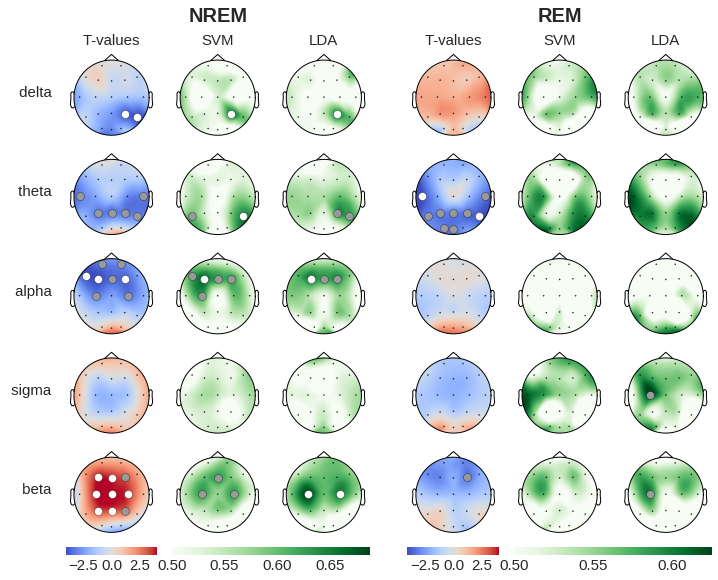

In [8]:
create_figure(diff,
              scores,
              features=["PSD_delta", "PSD_theta", "PSD_alpha", "PSD_sigma", "PSD_beta"],
              classifiers=["SVM", "LDA"],
              show=False,)
fname = "Figure1.pdf"
plt.savefig(os.path.join(FIGURE_PATH, fname), bbox_inches="tight", transparent=True)
plt.show()

NREM 0.75
REM 0.65


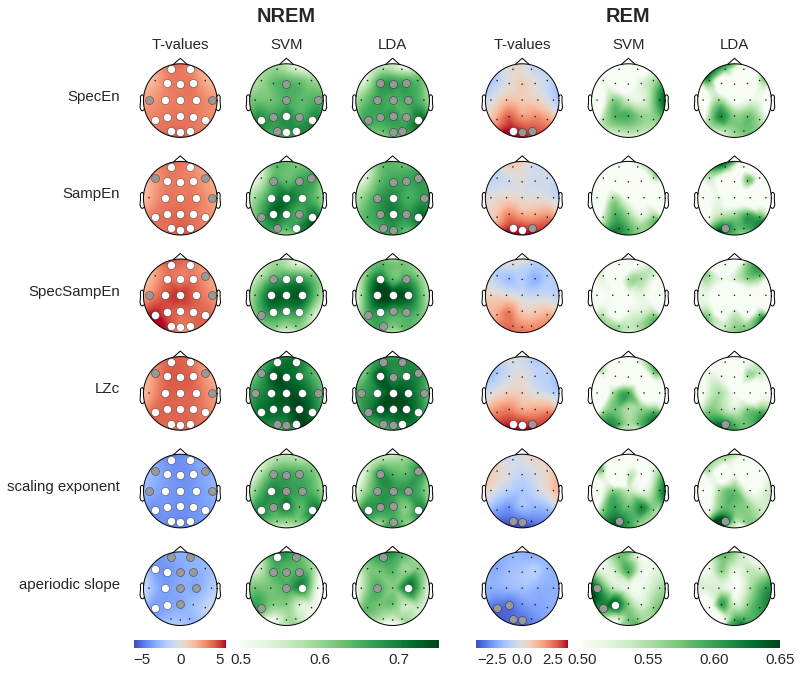

In [9]:
create_figure(diff,
              scores,
              features=["SpecShanEn", "SampEn", "SpecSampEn", "LZiv", "DFA", "OneOverF"],
              classifiers=["SVM", "LDA"],
              show=False,)
fname = "Figure3.pdf"
plt.savefig(os.path.join(FIGURE_PATH, fname), bbox_inches="tight",
            transparent=True)
plt.show()

# Create figure comparing age groups

In [10]:
age_suffixes = {-1: "", 0: "_age_t30", 1: "_age_f30"}
age_names = ["all\n(20 - 58)", "young\n(20 - 27)", "middle aged\n(41 - 58)"]

# load statistics data for all age groups
stats_all = {}
for i, suffix in age_suffixes.items():
    with open(os.path.join(STATS_RESULTS_PATH, f"statistics{suffix}.pickle"), "rb") as file:
        stats_all[i] = pickle.load(file)

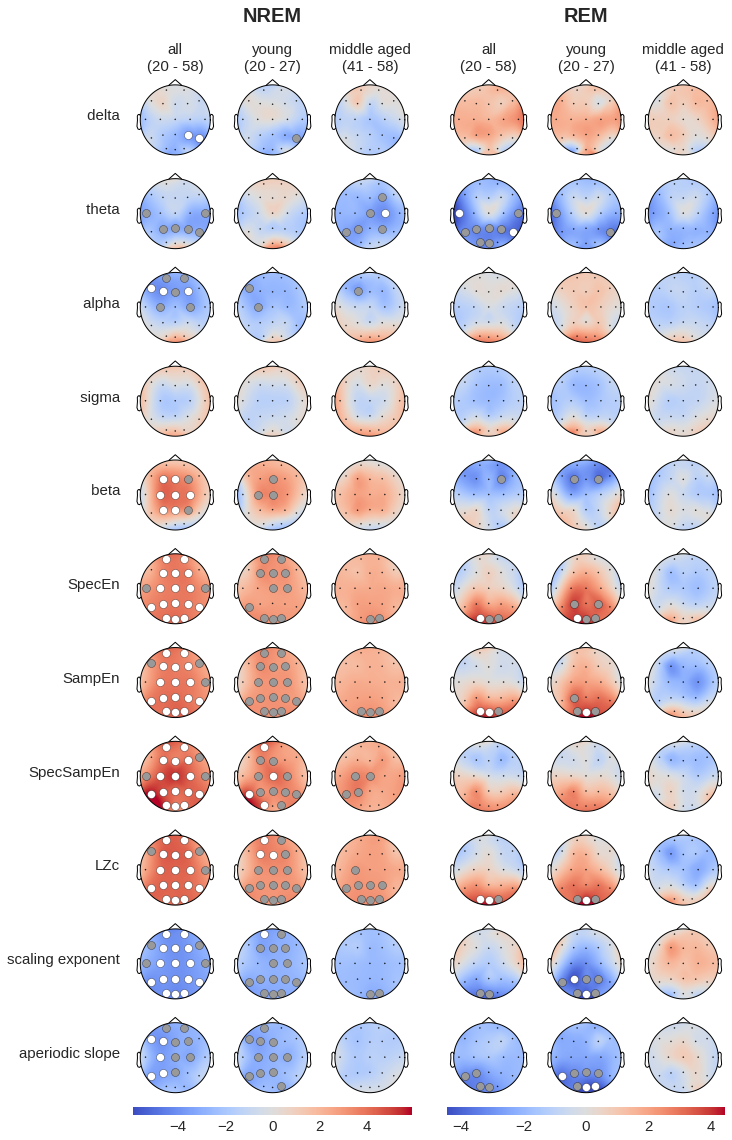

In [11]:
features = ["PSD_delta", "PSD_theta", "PSD_alpha", "PSD_sigma", "PSD_beta", "SpecShanEn", "SampEn", "SpecSampEn", "LZiv", "DFA", "OneOverF"]
colormap_stats = "coolwarm"
weak_marker_color = [0.6, 0.6, 0.6]
fontsize_small = 15
fontsize_big = 20

num_stages, num_ages, num_features = len(STAGES), len(stats_all), len(features)

fig, axes = plt.subplots(num_features + 1, num_stages * num_ages + (num_stages - 1) + 1,
                         figsize=(11, num_features * 1.5 + 1),
                         gridspec_kw=dict(width_ratios=sum([[0.1] + [1] * num_ages] * num_stages, []),
                                          height_ratios=[1] * num_features + [0.1],))

# annotate features
for i, feat in enumerate(features):
    feat = fmt_feat(feat)
    axes[i,0].annotate(feat, xy=(1, 0.5), ha='right', va='center', fontsize=fontsize_small)
    axes[i,0].axis("off")

# get gridspec and remove colorbar row of axes
gs = axes[0,0].get_gridspec()
for ax in axes[-1]:
    ax.remove()
# remove spacing axes
for i in range(1, len(STAGES)):
    for ax in axes[:-1, i * num_ages + 1]:
        ax.remove()

# add titles
for i in range(len(STAGES)):
    for j, age_name in enumerate(age_names):
        axes[0, i * (num_ages + 1) + 1 + j].set_title(age_name, fontsize=fontsize_small)

axes = axes[:,sum([[False] + [True] * num_ages] * num_stages, [])]
for i_stage, stage in enumerate(STAGES):
    # add sleep stage titles
    x_text = np.mean([
        (ax.get_position().x0 + ax.get_position().x1) / 2
        for ax in axes[0, i_stage * num_ages:(i_stage + 1) * num_ages]]
    )
    fig.text(x_text, 0.99, stage, fontsize=fontsize_big, ha="center", va="bottom", weight="bold")

    # compute statistics value range
    vmin_stats = min([min([min(stats_all[age][stage][feat]["t_statistic"]) for feat in features]) for age in age_suffixes.keys()])
    vmax_stats = max([max([max(stats_all[age][stage][feat]["t_statistic"]) for feat in features]) for age in age_suffixes.keys()])
    absvmax_stats = max(abs(vmin_stats), abs(vmax_stats))
    vmin_stats, vmax_stats = -absvmax_stats, absvmax_stats

    for i_age, age in enumerate(age_suffixes.keys()):
        for j_feat, feat in enumerate(features):
            # get significance marker params
            mask = stats_all[age][stage][feat]['p_value'] < SIGNIFICANT_P
            marker_colors = [weak_marker_color] * len(mask)
            for i in np.where(stats_all[age][stage][feat]['p_value'] < SIGNIFICANT_P_STRONG)[0]:
                marker_colors[i] = 'w'
            marker_colors = np.array(marker_colors)[mask]

            # plot topomap
            mappable_stats = plot_topomap(stats_all[age][stage][feat]['t_statistic'],
                                          sensor_pos,
                                          mask=mask,
                                          mask_params={'markersize': 8, 'markeredgewidth': 0.3, 'markerfacecolor': marker_colors},
                                          cmap=colormap_stats,
                                          axes=axes[j_feat, i_stage * num_ages + i_age],
                                          contours=False,
                                          show=False,
                                          vmin=vmin_stats,
                                          vmax=vmax_stats,)[0]

    ax = fig.add_subplot(gs[-1, i_stage * (num_ages + 1) + 1 : i_stage * (num_ages + 1) + (num_ages) + 1])
    mappable = cm.ScalarMappable(norm=colors.Normalize(vmin=vmin_stats, vmax=vmax_stats), cmap=colormap_stats)
    fig.colorbar(mappable, cax=ax, orientation="horizontal")

plt.savefig(os.path.join(FIGURE_PATH, "Figure5.pdf"), bbox_inches="tight", transparent=True)
plt.show()